# 二次响应面模型(Quadratic Response Surface Model, QRSM)

## 模型描述：
$$
\begin{aligned}
y(\mathbf{x}) &= \hat{y}(\mathbf{x})+\varepsilon, \mathbf{x} \in \mathbb{R}^{m} \\
\hat{y}(\mathbf{x}) &= \beta_{0}+\sum_{i=1}^{m} \beta_{i} x_{i}+\sum_{i=1}^{m} \beta_{i i} x_{i}^{2}+\sum_{i=1}^{m} \sum_{j \geq i}^{m} \beta_{i j} x_{i} x_{j}
\end{aligned}
$$
系数可由以下公式得到：
$$
\boldsymbol{\beta}=\left(\mathbf{U}^{\mathrm{T}} \mathbf{U}\right)^{-1} \mathbf{U}^{\mathrm{T}} \mathbf{y}_{S}
$$
$$
\mathbf{U}=\left[\begin{array}{cccccccccc}
1 & x_{1}^{(1)} & \cdots & x_{m}^{(1)} & x_{1}^{(1)} x_{2}^{(1)} & \cdots & x_{m-1}^{(1)} x_{m}^{(1)} & \left(x_{1}^{(1)}\right)^{2} & \cdots & \left(x_{m}^{(1)}\right)^{2} \\
\vdots & \vdots & \ddots & \vdots & \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
1 & x_{1}^{(n)} & \cdots & x_{m}^{(n)} & x_{1}^{(n)} x_{2}^{(n)} & \cdots & x_{m-1}^{(n)} x_{m}^{(n)} & \left(x_{2}^{(n)}\right)^{2} & \cdots & \left(x_{m}^{(n)}\right)^{2}
\end{array}\right] \in \mathbb{R}^{n \times p} ,p=(m+1)(m+2) / 2
$$

In [18]:
import numpy as np

class QRSM():
    """ 
    Quadratic Response Surface Model. 
    
    input:  xs --- numpy array ([num*dim]), the inital samples.   
            ys --- numpy array ([num]), the response of xs.
            xlow --- numpy array ([num]), the low boundary of x.
            xup --- numpy array ([num]), the up boundary of x.
    fuction:    Model --- build the Quadratic Response Surface Model.
                Predict --- Predict response of the input sample. 
    """
    def __init__(self, xs, ys, xlow, xup):
        self.xs = xs
        self.ys = ys
        self.xlow = xlow
        self.xup = xup
        self.n = xs.shape[0] # the number of the inital samples
        self.m = xs.shape[1] # the dimension of desicion varibles
        self.p = int((self.m + 1) * (self.m + 2) / 2)
        self.U = np.ones([self.n, self.p])
        self.beta = np.zeros([self.p, 1])

        # normalize the desicion varibles
        for i in range(self.m):
            self.xs[:, i] = (self.xs[:, i] - xlow[i]) / (xup[i] - xlow[i])

    def Model(self):
        """
        Build the Quadratic Response Surface Model.
        """
        # Define the matrix U
        for index in range(1, self.m+1): # the linear items.
            j = index - 1
            for i in range(self.n):
                self.U[i][index] = self.xs[i][j]
        index = self.m+1 # the crossover items.
        for j in range(self.m-1):
            for k in range(j+1, self.m):
                for i in range(self.n):
                    self.U[i][index] = self.xs[i][j] * self.xs[i][k]
                index += 1
        for index in range(int(self.m+1+self.m*(self.m-1)/2), self.p): # the quadratic items
            j = index - int(self.m+1+self.m*(self.m-1)/2)
            for i in range(self.n):
                self.U[i][index] = self.xs[i][j]**2

        # Calculate the coefficients
        self.beta = np.dot(self.U.T, self.U)
        if(np.linalg.det(self.beta) == 0):
            print("The matrix UT*U is a singular matrix")
            quit()
        self.beta = np.linalg.inv(np.dot(self.U.T, self.U))
        self.beta = np.dot(self.beta, self.U.T)
        self.beta = np.dot(self.beta, self.ys.reshape(self.n, 1))

    def Predict(self, x):
        """
        Prediction by RSM

        input: x --- numpy array (dim), the preditive sample
        output: y --- float number, the prediction by RSM
        """
        x = x.reshape(dim)

        for i in range(self.m):
            x[i] = (x[i] - self.xlow[i]) / (self.xup[i] - self.xlow[i])

        predict0 = self.beta[0, 0]
        predict1 = 0 # the linear items.
        for index in range(1, self.m+1):
            j = index - 1
            predict1 += self.beta[index,0] * x[j]
        predict2 = 0 # the crossover items.
        index = self.m+1 
        for j in range(self.m-1):
            for k in range(j+1, self.m):
                predict2 += self.beta[index,0] + x[j] * x[k]
                index += 1
        predict3 = 0 # the quadratic items
        for index in range(int(self.m+1+self.m*(self.m-1)/2), self.p): 
            j = index - int(self.m+1+self.m*(self.m-1)/2)
            predict3 += self.beta[index,0] * x[j]**2

        return predict0 + predict1 + predict2 + predict3


## Test

选用一维Forrest函数

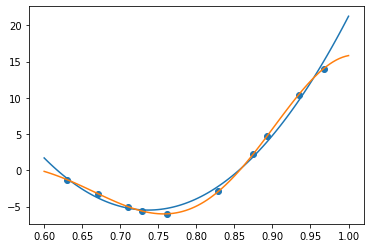

In [42]:
import random
import matplotlib.pyplot as plt

def LHS(n,d):
    x = np.zeros([n,d])
    p = np.linspace(0,n-1,n)
    for j in range(d):
        random.shuffle(p)
        for i in range(n):    
            x[i,j] = ( p[i] + random.random() ) / n
    return x

def forrester(x):
    y =  (6*x-2)**2 * np.sin(12*x-4)
    return y

dim = 1
num_init = 10
xs = LHS(num_init, dim)
#xlow = np.zeros(dim)
xlow = np.array([0.6])
xup = np.ones(dim)
xs = xs*(1.0-0.6)+0.6
ys = forrester(xs)

model = QRSM(xs=xs, ys=ys, xlow=xlow, xup=xup)
model.Model()

x = np.linspace(0.6, 1,100).reshape(100,1)
y = np.zeros(100)
yture = np.zeros(100)
for i in range(100):
    y[i] = model.Predict(x[i])
x = np.linspace(0.6, 1,100).reshape(100,1)
yture = forrester(x)

plt.plot(x, y)
plt.plot(x, yture)
xs = xs*(1.0-0.6)+0.6
plt.scatter(xs, ys)
plt.show()


In [15]:
import numpy as np
x = np.zeros([2,3])
y = np.zeros([3,1])
z = 0
x = np.linspace(0,1,100).reshape(100,1)
print(x[1])

[0.01010101]
